# Système de recommandation et deep learning


Buts:
- Comprendre les données des recommandations
- Construire différentes architectures de modèles en utilisant Keras
- Récupérer les incorporations et les visualiser
- Ajouter des informations de métadonnées en entrée du modèle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

Extracting ml-100k.zip to ml-100k...



### Fichier de ratings

Chaque ligne contient un film classé:

- un utilisateur
- un élément
- une note de 1 à 5 étoiles

In [2]:
import pandas as pd

raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
raw_ratings.shape

(100000, 4)

In [4]:
raw_ratings.item_id.nunique()

1682

In [5]:
raw_ratings.user_id.nunique()

943

### Fichier de métadonnées d'élément

Le fichier de métadonnées d'élément contient des métadonnées telles que le nom du film ou la date de sa sortie. Le fichier de films contient des colonnes indiquant les genres du film. Chargons uniquement les cinq premières colonnes du fichier avec `usecols`.

In [6]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             1682 non-null   int64  
 1   title               1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   imdb_url            1679 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 65.8+ KB


On veut extraire l'année

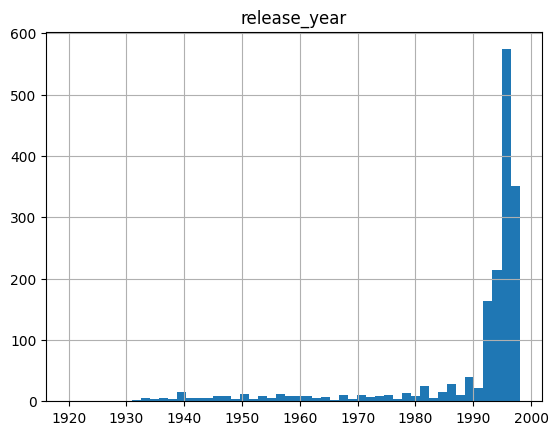

In [8]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


items['release_year'] = items['release_date'].map(extract_year)
items.hist('release_year', bins=50);

In [9]:
all_ratings = pd.merge(items, raw_ratings,
                       on="item_id",
                       how="inner")

In [10]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


### Prétraitement des données

On calcule quelques statistiques

In [11]:
all_ratings[['user_id', 'item_id', 'rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,100000.0,462.48475,266.614420,1.0,254.0,447.0,682.0,943.0
item_id,100000.0,425.53013,330.798356,1.0,175.0,322.0,631.0,1682.0
rating,100000.0,3.52986,1.125674,1.0,3.0,4.0,4.0,5.0


On recherche la popularité d'un film :

In [12]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)
items.nlargest(10, 'popularity')

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
49,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
257,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
99,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
180,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
293,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
285,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
287,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
299,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997
120,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,1996


In [13]:
items.iloc[181]

,181
item_id,182
popularity,226
title,GoodFellas (1990)
release_date,01-Jan-1990
video_release_date,NaN
imdb_url,http://us.imdb.com/M/title-exact?GoodFellas%20...
release_year,1990


In [14]:
indexed_items = items.set_index('item_id')
indexed_items.iloc[181]

,182
popularity,226
title,GoodFellas (1990)
release_date,01-Jan-1990
video_release_date,NaN
imdb_url,http://us.imdb.com/M/title-exact?GoodFellas%20...
release_year,1990


In [16]:
all_ratings = pd.merge(popularity, all_ratings, on="item_id")
all_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
item_id,100000.0,4.255301e+02,3.307984e+02,1.0,175.0,322.0,631.0,1682.0
popularity,100000.0,1.680719e+02,1.217846e+02,1.0,71.0,145.0,239.0,583.0
video_release_date,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,100000.0,1.987950e+03,1.416956e+01,1920.0,1986.0,1994.0,1996.0,1998.0
user_id,100000.0,4.624848e+02,2.666144e+02,1.0,254.0,447.0,682.0,943.0
rating,100000.0,3.529860e+00,1.125674e+00,1.0,3.0,4.0,4.0,5.0
timestamp,100000.0,8.835289e+08,5.343856e+06,874724710.0,879448709.5,882826944.0,888259984.0,893286638.0


In [17]:
all_ratings[all_ratings.item_id == 181]

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
26164,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,25,5,885853415
26165,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,194,3,879521396
26166,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,231,4,888605273
26167,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,298,4,884125629
26168,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,245,4,888513664
...,...,...,...,...,...,...,...,...,...,...
26666,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,708,5,877325279
26667,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,889,4,880177131
26668,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,554,4,876550100
26669,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997,577,5,880474612


On va séparer les données en apprentissage / test :

In [18]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Explicit feedback: prédiction des notes supervisées

Pour chaque paire de (utilisateur, item), essayez de prédire la note que l'utilisateur attribuerait à l'élément.

Il s'agit de la configuration classique pour créer des systèmes de recommandation à partir de données hors ligne avec un signal explicite.


## Notation prédictive vu comme un problème de régression

<img src="https://data-and-dev.com/images/rec_archi_1.svg" style="width: 600px;" />

In [19]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model

In [20]:
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')

        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        y = self.dot([user_vecs, item_vecs])
        return y

max_user_id = all_ratings.user_id.max()
max_item_id = all_ratings.item_id.max()

model = RegressionModel(64, max_user_id, max_item_id)
model.compile(optimizer="adam", loss='mae')

In [21]:
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


(80000, 1)


### La surveillance

Keras permet de surveiller diverses variables pendant l'entraînement.

`history.history` renvoyé par la fonction` model.fit` est un dictionnaire
contenant la `` perte '' et la perte de validation `` val_loss '' après chaque époque


In [22]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3.2891 - val_loss: 1.0346
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9026 - val_loss: 0.7924
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7561 - val_loss: 0.7710
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7223 - val_loss: 0.7557
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7055 - val_loss: 0.7458
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6809 - val_loss: 0.7421
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6648 - val_loss: 0.7397
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6404 - val_loss: 0.7374
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6210 - val_loss: 0.7364
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5921 - val_loss: 0.7404
CPU times: user 46.6 s, sys: 3.2 s, total: 49.8 s
Wall time: 42 s


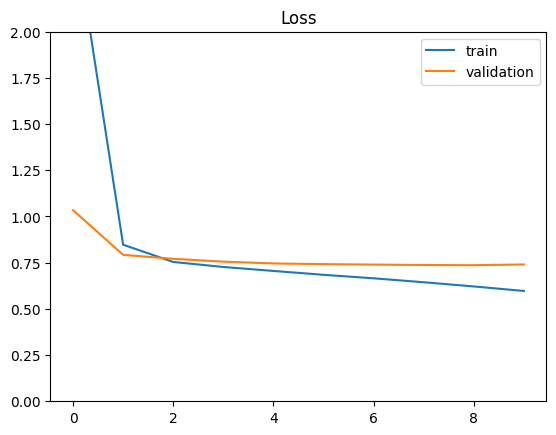

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [24]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.xlabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final test MSE: 0.908
Final test MAE: 0.734


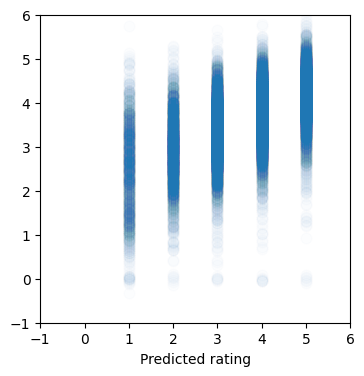

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Final train MSE: 0.628
Final train MAE: 0.579


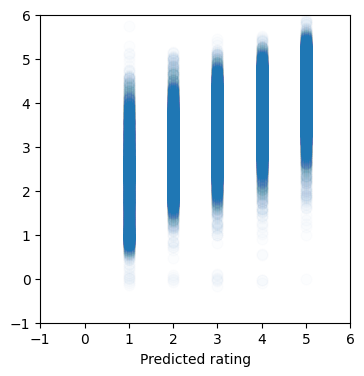

In [26]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))
plot_predictions(rating_train, train_preds)

### Embeddings

- Il est possible de récupérer les embeddings en utilisant simplement la fonction Keras `model.get_weights` qui retourne tous les paramètres apprenables du modèle.
- Les poids sont retournés dans le même ordre qu'ils ont été construits dans le modèle
- Quel est le nombre total de paramètres?

In [27]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [28]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [29]:
item_id = 181
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=181: Return of the Jedi (1983)


In [30]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=181
[ 0.34934643 -0.35525224  0.26344833  0.04940085 -0.20174225  0.33239737
 -0.16906287  0.44978273  0.17458984 -0.13803104  0.12961976 -0.31786552
  0.06783685  0.28047082 -1.0425874   0.39055842  0.22079028 -0.16626827
 -0.34703422  0.27933753  0.50277865 -0.2679765   0.44062263  0.3428718
 -0.14095302  0.01545851  0.02892901  0.11528519 -0.36573306  0.23594597
  0.3961215   0.13873985 -0.304661   -0.26672372 -0.35734487 -0.23371749
  0.05006263  0.44193515  0.3566497   0.3501567  -0.36940637 -0.17031503
 -0.38003272  0.39214402  0.4849471  -0.24879648  0.22562224 -0.28571925
  0.3728578   0.4270941   0.31136358  0.08369641 -0.4516992  -0.05441332
 -0.49754897 -0.10604266 -0.50413746 -0.35773382 -0.14783508  0.46422407
  0.39395288  0.3894875  -0.2870914   0.24470393]
shape: (64,)


### Recherche des items les plus similaires

Recherche de k éléments les plus similaires à un point de l'espace

- Ecrire en numpy une fonction pour calculer la similitude cosinus entre deux points dans l'espace d'intégration.
- Testez-le sur les cellules suivantes pour vérifier les similitudes entre les films populaires.
- Bonus: essayez de généraliser la fonction pour calculer les similitudes entre un film et tous les autres et renvoyer les films les plus liés.

Remarques:
- vous pouvez utiliser `np.linalg.norm` pour calculer la norme du vecteur, et vous pouvez spécifier le ʻaxis =`
- la fonction numpy `np.argsort (...)` permet de calculer les indices triés d'un vecteur
- ʻitems ["nom"] [idxs] `retourne les noms des éléments indexés par le tableau idxs

In [31]:
EPSILON = 1e-07  # to avoid division by 0.


def cosine(x, y):
    dot_products = np.dot(x, y.T)
    norm_products = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_products / (norm_products + EPSILON)

In [32]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")

print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.917


In [33]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.705


In [ ]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.832


In [34]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 1.0


In [35]:
def cosine_similarities(item_id, item_embeddings):
    """Compute similarities between item_id and all items embeddings"""
    query_vector = item_embeddings[item_id]
    dot_products = item_embeddings @ query_vector

    query_vector_norm = np.linalg.norm(query_vector)
    all_item_norms = np.linalg.norm(item_embeddings, axis=1)
    norm_products = query_vector_norm * all_item_norms
    return dot_products / (norm_products + EPSILON)


similarities = cosine_similarities(181, item_embeddings)
similarities

array([0.18749456, 0.7629991 , 0.75835705, ..., 0.69124925, 0.8157534 ,
       0.6216952 ], dtype=float32)

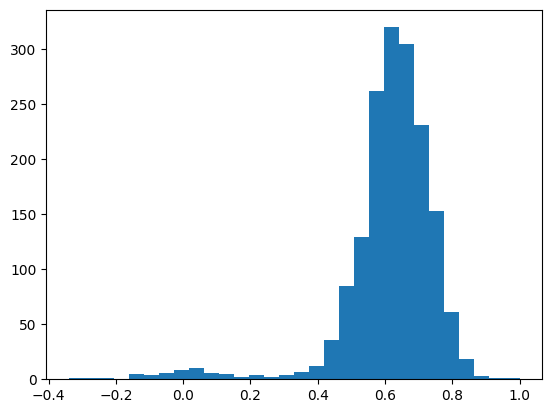

In [36]:
plt.hist(similarities, bins=30);

In [37]:
def most_similar(item_id, item_embeddings, titles,
                 top_n=30):
    sims = cosine_similarities(item_id, item_embeddings)
    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(zip(idxs, titles[idxs], sims[idxs]))


most_similar(50, item_embeddings, indexed_items["title"], top_n=10)

[(np.int64(50), 'Star Wars (1977)', np.float32(1.0)),
 (np.int64(181), 'Return of the Jedi (1983)', np.float32(0.9173281)),
 (np.int64(172), 'Empire Strikes Back, The (1980)', np.float32(0.90857404)),
 (np.int64(12), 'Usual Suspects, The (1995)', np.float32(0.89158237)),
 (np.int64(174), 'Raiders of the Lost Ark (1981)', np.float32(0.8803395)),
 (np.int64(228),
  'Star Trek: The Wrath of Khan (1982)',
  np.float32(0.87412864)),
 (np.int64(408), 'Close Shave, A (1995)', np.float32(0.8698338)),
 (np.int64(173), 'Princess Bride, The (1987)', np.float32(0.85743296)),
 (np.int64(89), 'Blade Runner (1982)', np.float32(0.8570894)),
 (np.int64(7), 'Twelve Monkeys (1995)', np.float32(0.8540301))]

In [38]:
items[items['title'].str.contains("Star Trek")]

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
221,222,365,Star Trek: First Contact (1996),22-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,1996
226,227,161,Star Trek VI: The Undiscovered Country (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1991
227,228,244,Star Trek: The Wrath of Khan (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,1982
228,229,171,Star Trek III: The Search for Spock (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1984
229,230,199,Star Trek IV: The Voyage Home (1986),01-Jan-1986,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1986
379,380,116,Star Trek: Generations (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,1994
448,449,117,Star Trek: The Motion Picture (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Star%20Trek:%...,1979
449,450,63,Star Trek V: The Final Frontier (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...,1989


In [39]:
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(np.int64(227),
  'Star Trek VI: The Undiscovered Country (1991)',
  np.float32(0.9999999)),
 (np.int64(183), 'Alien (1979)', np.float32(0.89369756)),
 (np.int64(228),
  'Star Trek: The Wrath of Khan (1982)',
  np.float32(0.88618904)),
 (np.int64(429),
  'Day the Earth Stood Still, The (1951)',
  np.float32(0.8829765)),
 (np.int64(1552), 'Hunted, The (1995)', np.float32(0.8730712)),
 (np.int64(172), 'Empire Strikes Back, The (1980)', np.float32(0.8676521)),
 (np.int64(181), 'Return of the Jedi (1983)', np.float32(0.86485493)),
 (np.int64(109),
  'Mystery Science Theater 3000: The Movie (1996)',
  np.float32(0.8615896)),
 (np.int64(1130), "Jupiter's Wife (1994)", np.float32(0.8604341)),
 (np.int64(1485), 'Colonel Chabert, Le (1994)', np.float32(0.8594381))]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

## A Deep recommender model

<img src="https://www.data-and-dev.com/images/rec_archi_2.svg" style="width: 600px;" />


Pour construire ce modèle, nous aurons besoin d'un nouveau type de couche:

In [40]:
from tensorflow.keras.layers import Concatenate


### Exercice

In [41]:
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()

        self.dropout = Dropout(0.5)
        self.dense1 = Dense(64, activation="relu")
        self.dense2 = Dense(1)

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        input_vecs = self.concat([user_vecs, item_vecs])

        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dense2(y)

        return y

model = DeepRegressionModel(64, max_user_id, max_item_id)
model.compile(optimizer='adam', loss='mse')

initial_train_preds = model.predict([user_id_train, item_id_train])

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [42]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.4209 - val_loss: 0.9180
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9216 - val_loss: 0.9042
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8903 - val_loss: 0.9092
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8755 - val_loss: 0.8859
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8515 - val_loss: 0.8812
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8455 - val_loss: 0.8807
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.8374 - val_loss: 0.8773
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.8236 - val_loss: 0.8859
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8197 - val_loss: 0.8701
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8027 - val_loss: 0.8702
CPU times: user 56.9 s, sys: 3.55 s, total: 1min
Wall time: 54.4 s


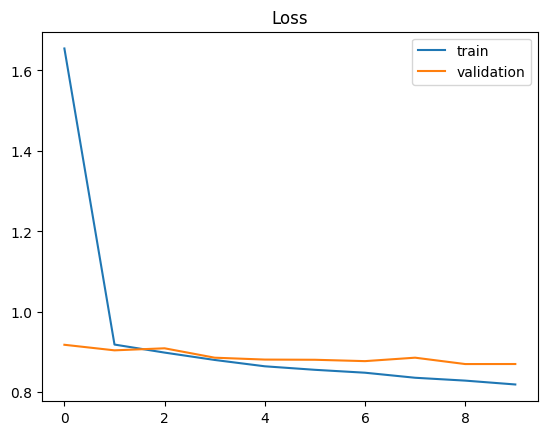

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.title('Loss');

In [44]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Final train MSE: 0.765
Final train MAE: 0.689


In [45]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final test MSE: 0.868
Final test MAE: 0.735


Les performances de ce modèle ne sont pas forcément nettement meilleures que le modèle précédent mais vous pouvez remarquer que l'écart entre l'apprentissage et le test est plus faible, probablement grâce à l'utilisation du dropout.

De plus, ce modèle est plus flexible en ce sens que nous pouvons l'étendre pour inclure des métadonnées pour les recsys hybrides comme nous le verrons dans ce qui suit.

## Utilisation des métadonnées d'élément dans le modèle

En utilisant un cadre similaire à celui précédemment, nous allons créer un autre modèle profond qui peut également exploiter des métadonnées supplémentaires. Le système qui en résulte est donc un **système de recommandation hybride** qui effectue à la fois le **filtrage collaboratif** et les **recommandations basées sur le contenu**.

<img src="https://www.data-and-dev.com/images/rec_archi_3.svg" style="width: 600px;" />


In [46]:
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'release_year']

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [47]:
class HybridModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        name='item_embedding')

        self.flatten = Flatten()
        self.concat = Concatenate()

        self.dense1 = Dense(64, activation="relu")
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(64, activation='relu')
        self.dense3 = Dense(1)

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        meta_inputs = inputs[2]


        user_emb = self.user_embedding(user_inputs)
        user_vecs = self.flatten(user_emb)
        user_vecs = self.dropout(user_vecs, training=training)

        item_vecs = self.flatten(self.item_embedding(item_inputs))
        item_vecs = self.dropout(item_vecs, training=training)

        input_vecs = self.concat([user_vecs, item_vecs, meta_inputs])

        y = self.dense1(input_vecs)
        y = self.dropout(y,training=training)
        y = self.dense2(y)
        y = self.dropout(y, training=training)
        y = self.dense3(y)
        return y

model = HybridModel(64, max_user_id, max_item_id)

model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train,
                                     item_id_train,
                                     item_meta_train])

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [48]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train],
                    rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.2751 - val_loss: 0.7687
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.8164 - val_loss: 0.7442
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7912 - val_loss: 0.7430
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7740 - val_loss: 0.7336
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7602 - val_loss: 0.7278
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7461 - val_loss: 0.7304
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7305 - val_loss: 0.7219
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7244 - val_loss: 0.7187
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7123 - val_loss: 0.7230
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7039 - val_loss: 0.7162
CPU times: user 1min 3s, sys: 3.82 s, total: 1min 6s
Wall time: 1min 8s


In [49]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Final test MSE: 0.866
Final test MAE: 0.715


Les métadonnées supplémentaires semblent améliorer un peu la puissance prédictive du modèle, mais cela devrait être réexécuté plusieurs fois pour voir l'impact de l'initialisation aléatoire du modèle.


### Une fonction de recommandation pour un utilisateur donné

Une fois le modèle entraîné, le système peut être utilisé pour recommander quelques éléments à un utilisateur, qu'il n'a pas encore vu:
- nous utilisons le `model.predict` pour calculer les notes qu'un utilisateur aurait donné à tous les éléments
- nous construisons une fonction de reco qui trie ces éléments et exclut ceux que l'utilisateur a déjà vus

In [50]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    print("User %d has seen %d movies, including:" % (user_id, len(seen_movies)))
    for title in all_ratings[seen_mask].nlargest(20, 'popularity')['title']:
        print("   ", title)
    print("Computing ratings for %d other movies:" % len(item_ids))

    item_ids = np.array(item_ids)
    user_ids = np.zeros_like(item_ids)
    user_ids[:] = user_id
    items_meta = scaler.transform(indexed_items[meta_columns].loc[item_ids])

    rating_preds = model.predict([user_ids, item_ids, items_meta])

    item_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["title"][movie], rating_preds[movie][0])
            for movie in rec_items]

In [51]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

User 5 has seen 175 movies, including:
    Star Wars (1977)
    Fargo (1996)
    Return of the Jedi (1983)
    Toy Story (1995)
    Independence Day (ID4) (1996)
    Raiders of the Lost Ark (1981)
    Silence of the Lambs, The (1991)
    Empire Strikes Back, The (1980)
    Star Trek: First Contact (1996)
    Back to the Future (1985)
    Mission: Impossible (1996)
    Fugitive, The (1993)
    Indiana Jones and the Last Crusade (1989)
    Willy Wonka and the Chocolate Factory (1971)
    Princess Bride, The (1987)
    Forrest Gump (1994)
    Monty Python and the Holy Grail (1974)
    Men in Black (1997)
    E.T. the Extra-Terrestrial (1982)
    Birdcage, The (1996)
Computing ratings for 1506 other movies:
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
    4.4: Madness of King George, The (1994)
    4.4: Under Siege (1992)
    4.3: Richard III (1995)
    4.3: Raging Bull (1980)
    4.3: Raising Arizona (1987)
    4.3: Star Trek: First Contact (1996)
    4.3: August (1996)
    4.3: Citizen Ruth (1